In [2]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np

from tqdm import tqdm
from scipy.interpolate import interp1d

%matplotlib inline

plt.style.use(["science","bright","grid"])

In [3]:
def run_magic_cable(time_steps, voltages, topology_parameter, radius=1e6, eq_steps=0):

    np_info2 = {
        'np_index'      : [topology_parameter["Nx"]-1], 
        'mean_radius'   : radius,
        'std_radius'    : 0.0
    }

    target_electrode    = len(topology_parameter["e_pos"])-1
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, np_info2=np_info2)
    sim_class.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, stat_size=50, save=False, eq_steps=eq_steps)
    results             = sim_class.return_output_values()

    return results

## String

In [5]:
radius  = 1e5
results = []
N_min   = 2
N_max   = 20

for N_p in tqdm(np.arange(N_min,N_max+1,1)):

    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : 1,
        "Nz"                : 1,
        "e_pos"             : [[0,0,0],[N_p-1,0,0]],
        "electrode_type"    : ['constant','floating']
    }

    if topology_parameter["electrode_type"][-1] == 'floating':
        potential = True
    else:
        potential = False

    # Voltage Paramter
    N_voltages              = 1000
    amplitudes              = [0.1,0.0]
    frequencies             = [1e5,0.0]
    time_step               = 1e-7
    time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                                amplitudes=amplitudes, frequencies=frequencies, time_step=time_step)
    
    val = run_magic_cable(time_steps, voltages, topology_parameter, radius, 0)
    results.append(val)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [06:12<00:00, 19.58s/it]


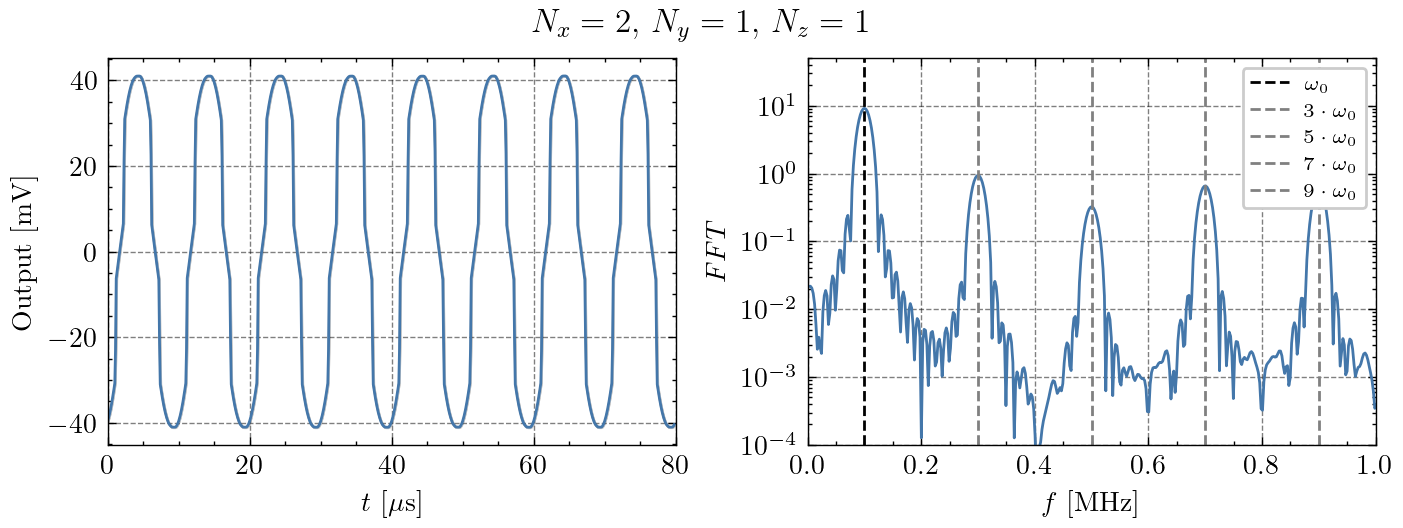

In [25]:
y_min   = 0.0001
y_max   = 50
f1      = 0.1
eq_step = 200
val_eq  = results[0][eq_step:]
t_vals  = time_steps[:-(eq_step+1)]

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)

if potential:
    ax.plot(t_vals*1e6, val_eq[:,2]*1000)
    ax.fill_between(t_vals*1e6, val_eq[:,2]*1000-val_eq[:,3]*1000,
                    val_eq[:,2]*1000+val_eq[:,3]*1000, color='black', alpha=0.2)
else:
    ax.plot(t_vals*1e6, val_eq[:,2]/1000)
    ax.fill_between(t_vals*1e6, val_eq[:,2]/1000-val_eq[:,3]/1000,
                    val_eq[:,2]/1000+val_eq[:,3]/1000, color='black', alpha=0.2)
    
ax.set_xlabel('$t$ [$\mu$s]')
if potential:
    ax.set_ylabel('Output [mV]')
else:
    ax.set_ylabel('Output [nA]')
ax.set_xlim(0,80)

ax      = fig.add_subplot(1,2,2)
signal  = val_eq[:,2]
signal  = signal - np.mean(signal)
xf, f   = nanonets_utils.fft(signal=signal, dt=time_step, n_padded=4096)

ax.plot(xf/1e6 ,f)
ax.vlines(f1, y_min, y_max, colors='black', ls='--', label='$\omega_0$')
ax.vlines(3*f1, y_min, y_max, colors='grey', ls='--', label='$3 \cdot \omega_0$')
ax.vlines(5*f1, y_min, y_max, colors='grey', ls='--', label='$5 \cdot \omega_0$')
ax.vlines(7*f1, y_min, y_max, colors='grey', ls='--', label='$7 \cdot \omega_0$')
ax.vlines(9*f1, y_min, y_max, colors='grey', ls='--', label='$9 \cdot \omega_0$')
ax.set_xlim(0,1)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_yscale('log')
ax.legend(ncol=1, frameon=True, fontsize='x-small', framealpha=1, loc='upper right')
fig.suptitle(f'$N_x = {N_min}$, $N_y = 1$, $N_z = 1$')
fig.savefig(f"../plots/system_size/{N_min}_string_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/system_size/{N_min}_string_sample.pdf", bbox_inches='tight', transparent=False)

In [39]:
f0              = 1e5
harmonics       = []

for signal in results:
    arr_strength = nanonets_utils.harmonic_strength(signal=signal[:,2][eq_step:], f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

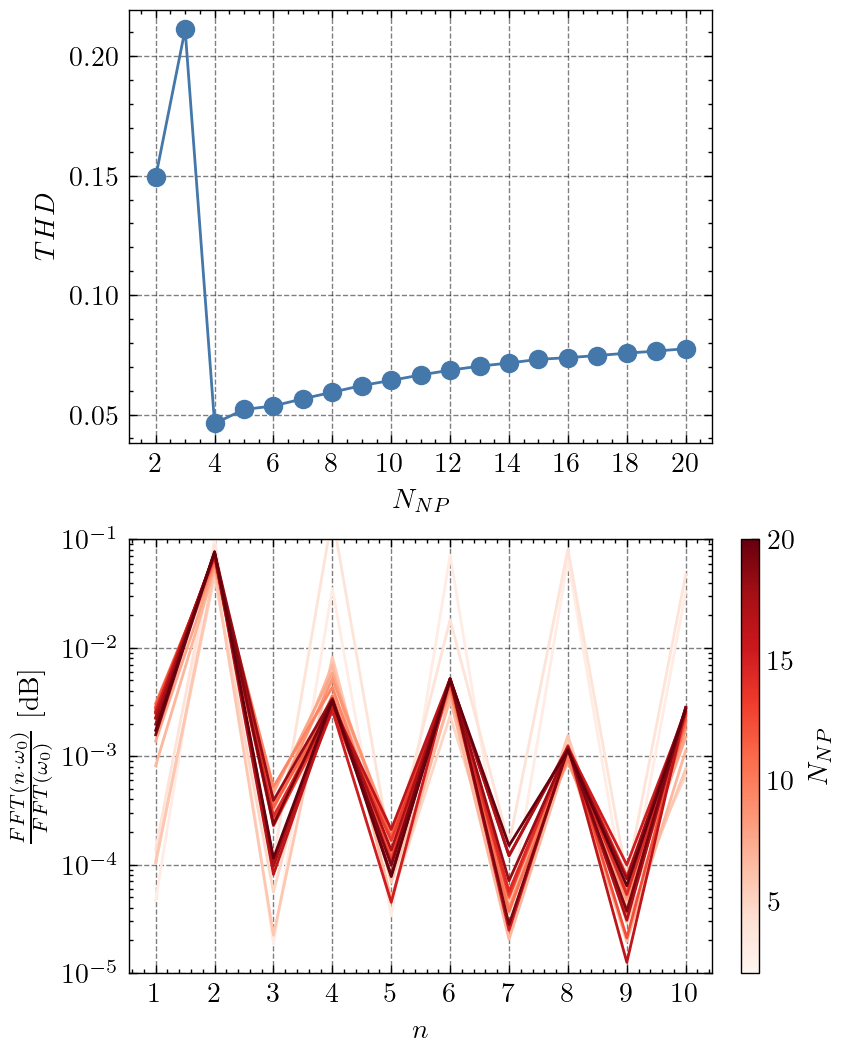

In [41]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figwidth(fig.get_figwidth()*1.2)
fig.set_figheight(fig.get_figheight()*2)

# ax  = fig.add_subplot(1,2,1)
ax  = fig.add_subplot(2,1,1)
ax.plot(np.arange(N_min,N_max+1,1), np.sqrt(np.sum(np.array(harmonics)**2, axis=1)), 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.arange(N_min,N_max+1,2))
ax.set_ylabel("$THD$")

# ax  = fig.add_subplot(1,2,2)
ax  = fig.add_subplot(2,1,2)
for i, arr_strength in enumerate(harmonics):
    ax.plot(np.arange(1, len(arr_strength)+1), arr_strength, color=cmap((i+1)/len(harmonics)))

ax.set_ylabel("$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$ [dB]")
ax.set_xlabel("$n$")
ax.set_xticks(np.arange(1, len(arr_strength)+1))
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e-1)

norm    = mpl.colors.Normalize(vmin=N_min, vmax=N_max)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(cbar, ax=ax, label='$N_{NP}$', fraction=1, aspect=25)
fig.savefig(f"../plots/system_size/THD_string_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/system_size/THD_string_sample.pdf", bbox_inches='tight', transparent=False)

## Network

In [34]:
radius      = 1e5
results_net = []
N_vals      = [3,5,7,9,11,13]

for N_p in tqdm(N_vals):

    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : N_p,
        "Nz"                : 1,
        "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],[0,(N_p-1)//2,0],
                            [N_p-1,(N_p-1)//2,0],[0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
        "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
    }

    if topology_parameter["electrode_type"][-1] == 'floating':
        potential = True
    else:
        potential = False

    # Voltage Paramter
    N_voltages              = 1000
    amplitudes              = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    frequencies             = [1e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    time_step               = 1e-7
    time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                                amplitudes=amplitudes, frequencies=frequencies, time_step=time_step)
    
    val = run_magic_cable(time_steps, voltages, topology_parameter, radius, 0)
    results_net.append(val)

100%|██████████| 6/6 [43:38<00:00, 436.38s/it]


In [42]:
f0              = 1e5
harmonics_net   = []

for signal in results_net:
    arr_strength = nanonets_utils.harmonic_strength(signal=signal[:,2][eq_step:], f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics_net.append(arr_strength)

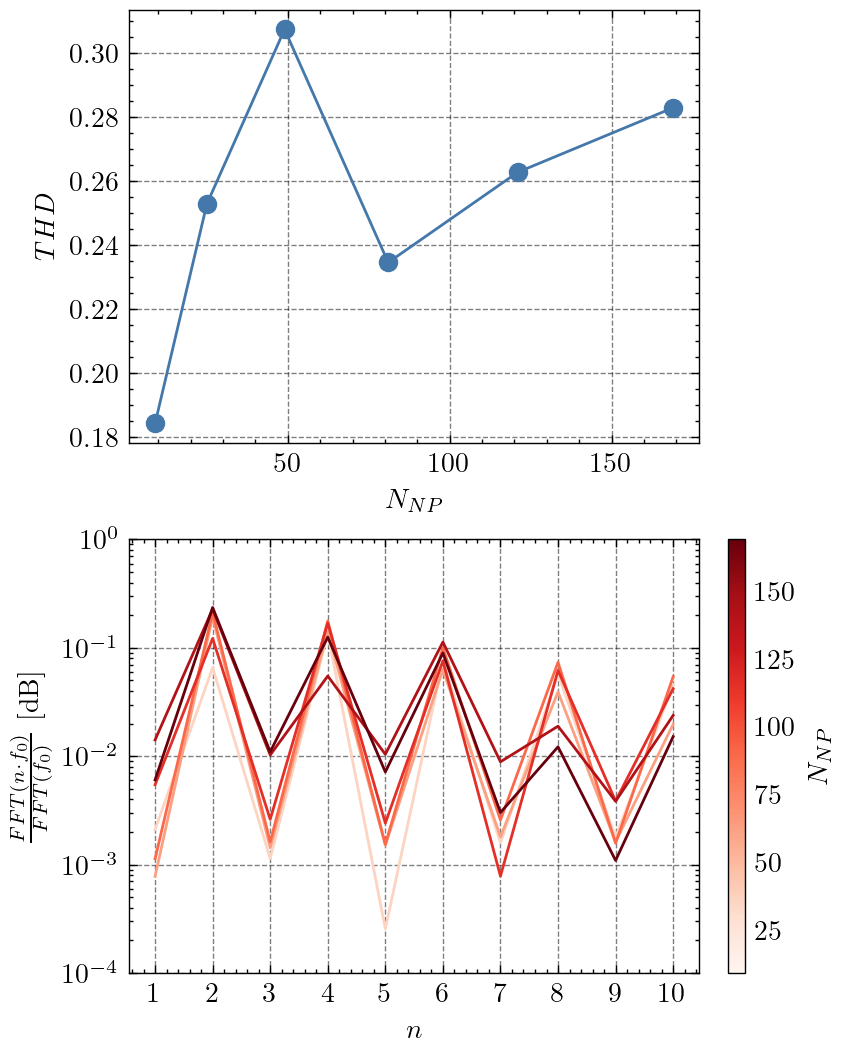

In [48]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figwidth(fig.get_figwidth()*1.2)
fig.set_figheight(fig.get_figheight()*2)

# ax  = fig.add_subplot(1,2,1)
ax  = fig.add_subplot(2,1,1)
ax.plot(np.array(N_vals)**2, np.sqrt(np.sum(np.array(harmonics_net)**2, axis=1)), 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_ylabel("$THD$")

# ax  = fig.add_subplot(1,2,2)
ax  = fig.add_subplot(2,1,2)
for i, arr_strength in enumerate(harmonics_net):
    ax.plot(np.arange(1, len(arr_strength)+1), arr_strength, color=cmap((i+1)/len(harmonics_net)))

ax.set_ylabel("$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$ [dB]")
ax.set_xlabel("$n$")
ax.set_yscale('log')
ax.set_ylim(1e-4, 1e0)
ax.set_xticks(np.arange(1, len(arr_strength)+1))

norm    = mpl.colors.Normalize(vmin=N_vals[0]**2, vmax=N_vals[-1]**2)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cbar, ax=ax, label='$N_{NP}$', fraction=1, aspect=25)
fig.savefig(f"../plots/system_size/THD_net_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/system_size/THD_net_sample.pdf", bbox_inches='tight', transparent=False)

---